## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Жолковский Евгений Константинович

In [3]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [8]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [9]:
images_train, labels_train = next(iter(train_loader))

In [10]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

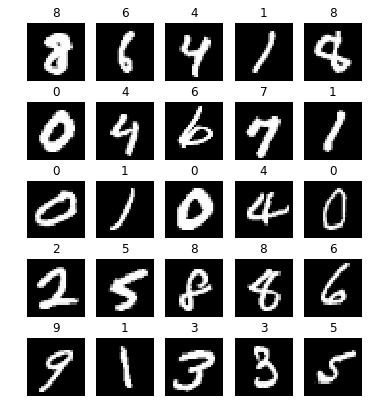

In [11]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:

def forward_hook(self, input_, output):

    std = input_[0].std().data[0]
    print ('forward', std)

def backward_hook(self, grad_input, grad_output):

    std = grad_input[0].std().data[0]
    print ('backward', std)


In [7]:
def new_linear_layer(input_size, output_size):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    layer.weight.data.zero_()
    return layer

In [8]:
##create layer with custom init function
def create_network():
    layers = []
    layers.append(new_linear_layer(784, 500))
    layers.append(nn.ReLU())
    for i in range(10):
        layers.append(new_linear_layer(500, 500))
        layers.append(nn.ReLU())

    layers.append(new_linear_layer(500, 10))
    layers.append(nn.LogSoftmax(dim=1))
    network = nn.Sequential(*layers)
    
    return network


In [9]:
create_network()

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

## Разные инициализации

In [10]:
def init_layer(layer, mean=0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

In [11]:
def init_he(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2./weight.shape[0]))

In [12]:
def init_xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    bound = np.sqrt(6. / (weight.shape[0] + weight.shape[1]))
    weight.uniform_(-bound,bound)

## Нормальная инициализация (0,0.1)

In [13]:
network = create_network()

for layer in network:
    if type(layer) == torch.nn.modules.linear.Linear:
        init_layer(layer, mean=0, std=np.sqrt(0.1))
        
        
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)

activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(activations, y)
loss.backward()

forward 0.9876730442047119
forward 5.267054557800293
forward 26.29094123840332
forward 129.4058837890625
forward 655.6019897460938
forward 3351.1845703125
forward 16690.794921875
forward 84607.984375
forward 408949.875
forward 2083249.625
forward 10484869.0
forward 52651768.0
backward 0.004221115726977587
backward 0.0029030069708824158
backward 0.014143119566142559
backward 0.07193956524133682
backward 0.3666120171546936
backward 1.8875635862350464
backward 9.40361213684082
backward 47.7379264831543
backward 235.90316772460938
backward 1161.105712890625
backward 5737.37939453125
backward 28960.810546875


## <i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

# He

In [14]:
network = create_network()

for layer in network:
    if type(layer) == torch.nn.modules.linear.Linear:
        init_he(layer)

n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)

activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(activations, y)
loss.backward()

forward 0.9876730442047119
forward 0.9964753985404968
forward 0.9898220896720886
forward 0.9688756465911865
forward 0.9927385449409485
forward 0.9382761716842651
forward 0.9130684733390808
forward 0.9425671696662903
forward 0.9676554203033447
forward 0.9849593043327332
forward 0.9836440086364746
forward 1.0239564180374146
backward 0.003956509754061699
backward 0.004098369739949703
backward 0.003956328146159649
backward 0.003990382421761751
backward 0.0040662563405931
backward 0.004105201456695795
backward 0.004181609023362398
backward 0.004162367898970842
backward 0.004306333139538765
backward 0.004402278922498226
backward 0.004348612390458584
backward 0.004232991486787796


## Xavier

In [15]:
network = create_network()

for layer in network:
    if type(layer) == torch.nn.modules.linear.Linear:
        pass
        init_xavier(layer)
        #torch.nn.init.xavier_uniform(layer.weight) - работают одинаково

n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)

activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(activations, y)
loss.backward()

forward 0.9876730442047119
forward 0.6475837826728821
forward 0.4750001132488251
forward 0.35585981607437134
forward 0.23826906085014343
forward 0.16072215139865875
forward 0.11473216861486435
forward 0.081612229347229
forward 0.057913508266210556
forward 0.04144668206572533
forward 0.02913358248770237
forward 0.019416743889451027
backward 0.0029993702191859484
backward 0.0004223646246828139
backward 0.0002963169536087662
backward 0.0002102425933117047
backward 0.00015168134996201843
backward 0.00010924565140157938
backward 7.777357677696273e-05
backward 5.46844930795487e-05
backward 3.82992293452844e-05
backward 2.6871553927776404e-05
backward 1.9357192286406644e-05
backward 1.3947018487669993e-05


<i> 1.4 Сделайте выводы по первой части </i>

## Выводы
Для сети с нелинейностью ReLU Инициализация весов дает существенное преимущество (особенно He). Для сети с нелинейностью Tahn разница невелика.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [4]:
use_cuda = torch.cuda.is_available() 
if use_cuda:
    torch.cuda.manual_seed(42)
    torch.cuda.set_device(1)
use_cuda

True

In [5]:
def train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False):
    loss = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
            
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                    
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                
                if use_cuda:
                    accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1)==y.data.cpu().numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            
            scheduler.step(loss_batch.data[0])

        
            
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                X = Variable(X)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                y = Variable(y)
                
                if use_cuda:
                    X, y = X.cuda(), y.cuda()

                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
                if use_cuda:
                    accuracies.append((np.argmax(prediction.data.cpu().numpy(), 1)==y.data.cpu().numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

## Просто сеть 784-200-200-10

In [144]:
network1 = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax(dim = 1))

torch.nn.init.xavier_uniform(network[0].weight)
torch.nn.init.xavier_uniform(network[2].weight)
torch.nn.init.xavier_uniform(network[4].weight)

if use_cuda:
    network1 = network1.cuda()

Epoch 49... (Train/Test) NLL: 0.008/0.153	Accuracy: 0.998/0.983

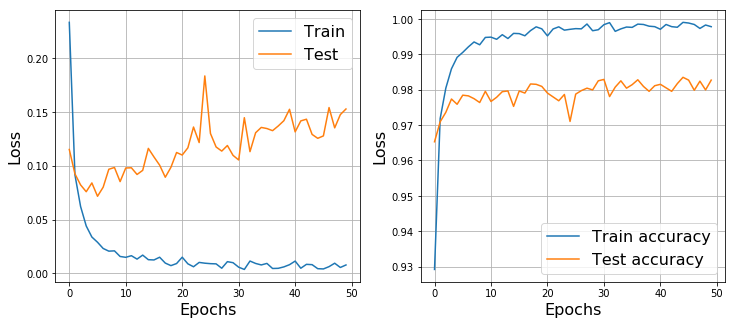

In [145]:
train(network, train_loader, test_loader, 50, 0.001, ravel_init=True)

## Dropout 0.2

In [147]:
network2 = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.2),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.2),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax(dim=1))

torch.nn.init.xavier_uniform(network2[0].weight)
torch.nn.init.xavier_uniform(network2[3].weight)
torch.nn.init.xavier_uniform(network2[6].weight)

if use_cuda:
    network2 = network2.cuda()

Epoch 41... (Train/Test) NLL: 0.021/0.087	Accuracy: 0.993/0.984Epoch    42: reducing learning rate of group 0 to 1.0000e-04.
Epoch 49... (Train/Test) NLL: 0.007/0.081	Accuracy: 0.998/0.985

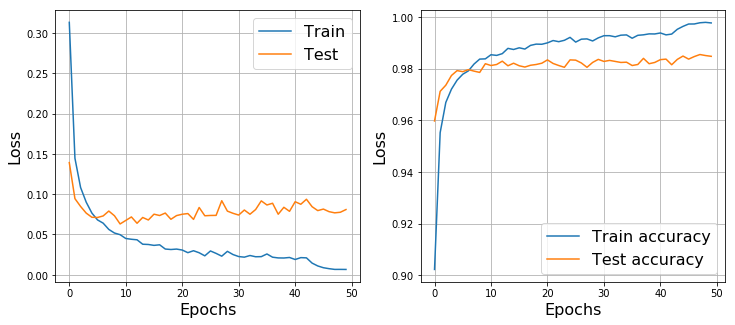

In [148]:
train(network2, train_loader, test_loader, 50, 0.001, ravel_init=True)

## Dropout 0.5

In [104]:
network3 = nn.Sequential(nn.Dropout(p=0.5),
                         nn.Linear(784, 200),
                         nn.ReLU(),
                         
                         nn.Dropout(p=0.5),
                         nn.Linear(200, 200),
                         nn.ReLU(),
                         
                         nn.Dropout(p=0.5),
                         nn.Linear(200, 10),
                         nn.LogSoftmax(dim=1)    
                        )
if use_cuda:
    network3 = network3.cuda()

Epoch 23... (Train/Test) NLL: 0.212/0.079	Accuracy: 0.937/0.976Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Epoch 38... (Train/Test) NLL: 0.168/0.069	Accuracy: 0.949/0.980Epoch    39: reducing learning rate of group 0 to 1.0000e-05.
Epoch 49... (Train/Test) NLL: 0.163/0.069	Accuracy: 0.950/0.980

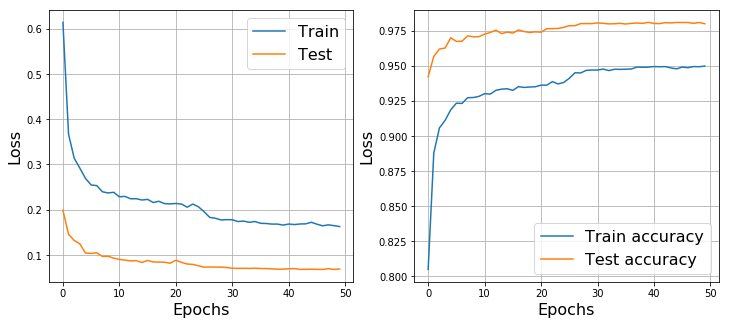

In [105]:
train(network3, train_loader, test_loader, 50, 0.001, ravel_init=True)

## Dropconnect - реализация

In [59]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size()) + (1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
            
        if use_cuda:
            mask = mask.cuda()
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

## Dropconnect

In [149]:
network4 = nn.Sequential(DropConnect(784, 200, p=0.5),
                         nn.ReLU(),
                         
                         DropConnect(200, 200, p=0.5),
                         nn.ReLU(),
                         
                         nn.Linear(200,10),
                         nn.LogSoftmax(dim=1)
                        )
if use_cuda:
    network4 = network4.cuda()

Epoch 49... (Train/Test) NLL: 0.045/0.071	Accuracy: 0.985/0.983

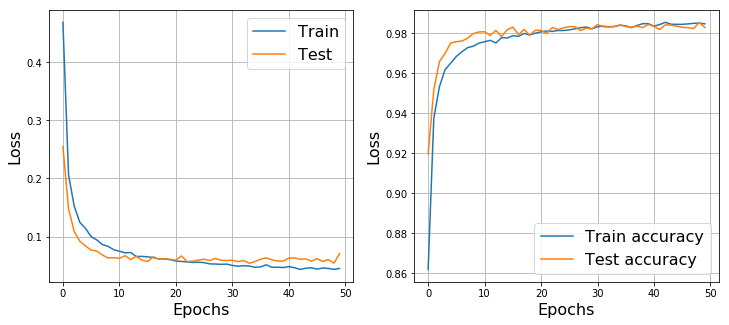

In [150]:
train(network4, train_loader, test_loader, 50, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по второй части </i>

   Эти методы позволяют бороться с переобучением. В сети без нормализации на учебной выборке очень рано достигается точность блищкая к 1 и сеть перестает обучаться. По графиками видно, что при использовании Dropout 0.5 и Dropconnect точность на тестовой выборке даже опережает точность учебной. Обучение при использовании этих методов замедляется. Нужно подбирать параметры выброса, чтобы сеть давала результат лучше, чем сеть, не использующая dropout или dropconnect. 

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

## 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization

In [120]:
network5 = nn.Sequential(nn.BatchNorm1d(784),
                         nn.Linear(784, 200),
                         nn.ReLU(),
                         
                         nn.BatchNorm1d(200),
                         nn.Linear(200, 200),
                         nn.ReLU(),
                         
                         nn.BatchNorm1d(200),
                         nn.Linear(200, 10),
                         nn.LogSoftmax(dim=1)    
                        )
if use_cuda:
    network5 = network5.cuda()

Epoch 40... (Train/Test) NLL: 0.004/0.535	Accuracy: 0.999/0.976Epoch    41: reducing learning rate of group 0 to 1.0000e-04.
Epoch 49... (Train/Test) NLL: 0.000/0.423	Accuracy: 1.000/0.978

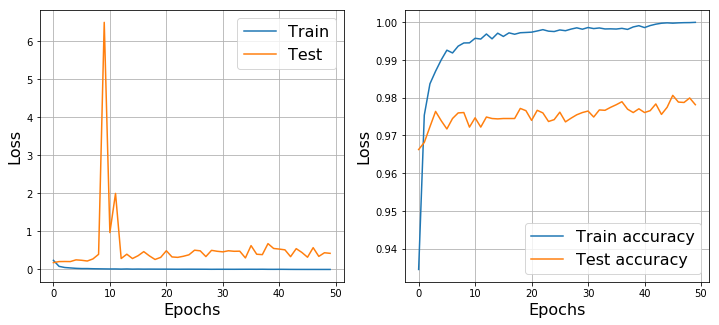

In [118]:
train(network5, train_loader, test_loader, 50, 0.001, ravel_init=True)

## 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization 

In [134]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        
        output = (x - mean) / (std + self.eps)
        return output
    

In [135]:
network6 = nn.Sequential(LayerNormalization(),
                         nn.Linear(784, 200),
                         nn.ReLU(),
                         
                         LayerNormalization(),
                         nn.Linear(200, 200),
                         nn.ReLU(),
                         
                         LayerNormalization(),
                         nn.Linear(200, 10),
                         nn.LogSoftmax(dim=1)    
                        )
if use_cuda:
    network6 = network6.cuda()

Epoch 24... (Train/Test) NLL: 0.005/0.101	Accuracy: 0.998/0.975Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Epoch 49... (Train/Test) NLL: 0.000/0.087	Accuracy: 1.000/0.985

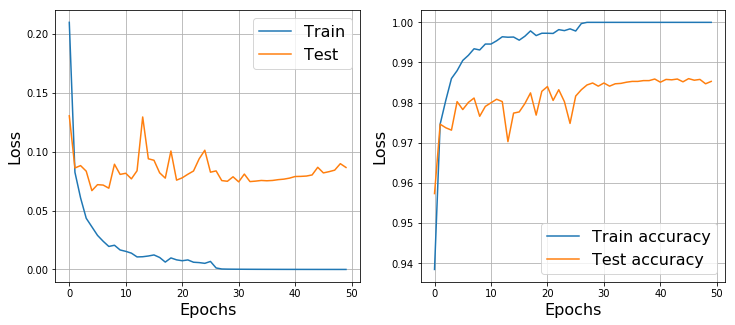

In [136]:
train(network6, train_loader, test_loader, 50, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

   Batch-normalization и layer-normalization существенно ускоряют обучение сети. В задаче номер 3 (про распознавание точек лица) без использования batch-normalization в независимости от архитектуры сети не удавалось получить хороший результат. Скорее всего была сходимость в локальный минимум. Недостатком было отсутствие возможности сделать предсказание для одного объекта. На задаче с распознованием цифры layer-normalization дает результат лучше, чем batch-normalization.